# DELIVERABLE 2 

## STEP 2: Random data generation

In [5]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 500
x_max         = 1000000    # maximum coordinates of a city on the x axis
y_max         = 1000000    # maximum coordinates of a city on the y axis

coords        = np.random.randint([x_max, y_max], size=(number_cities, 2))  # Creation of a random matrix of city coordinates

print(coords)

[[453499 809568]
 [656142  55502]
 [155434  38638]
 [814755 566221]
 [ 83445 544118]
 [793947 754108]
 [608850 832843]
 [606632 529583]
 [ 69313  79800]
 [753445 320429]
 [326788  98124]
 [ 93781 153380]
 [750020 716570]
 [936504 264449]
 [   355 694102]
 [722329  43857]
 [434157 175595]
 [538399 971562]
 [464571 858413]
 [328261 902810]
 [775117 153317]
 [266369 838076]
 [257775 416471]
 [539441  55929]
 [ 59606 836680]
 [234056 931467]
 [916967 158153]
 [313234 117607]
 [652413 676448]
 [199563 165173]
 [371846 125175]
 [445362 405770]
 [856664 288123]
 [928587 339630]
 [183778 160613]
 [576925 162928]
 [ 28077 562320]
 [639468 472496]
 [196993 643363]
 [673706  69928]
 [176938 179977]
 [829282  54573]
 [142903 718389]
 [714743 662664]
 [807728 557571]
 [608361 266227]
 [482763 110896]
 [760640 375569]
 [307761 831075]
 [254678 773600]
 [ 58490 848541]
 [ 78579  75162]
 [966397 304149]
 [331170 772539]
 [339935  25225]
 [292708 973933]
 [531459 958466]
 [799415 322374]
 [133010 11929

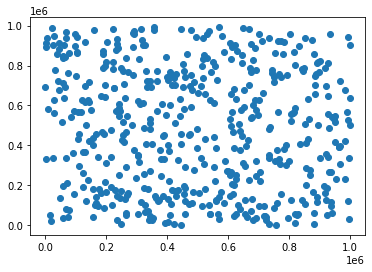

In [6]:
x, y = coords.T    # We define that the first value of coords is X and the second is Y
plt.scatter(x,y)   # Put the x and y axis in pyplot
plt.show()         # Display the coordinates of the cities on an orthonormal coordinate system

In [7]:

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Creation of the matrix of distances between cities
'''
df       = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
distance = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)

print(df)
print(distance)

     xcord   ycord
A   453499  809568
B   656142   55502
C   155434   38638
D   814755  566221
E    83445  544118
..     ...     ...
Ȱ   540058   52583
ȱ   965553  389584
Ȳ   675581  909243
ȳ   404869  218981
ȴ   421847    4825

[500 rows x 2 columns]
                A              B             C              D              E  \
A        0.000000  780819.901005  8.265445e+05  435572.795231  455415.925738   
B   780819.901005       0.000000  5.009919e+05  534782.180640  752813.024107   
C   826544.499180  500991.911871  0.000000e+00  844421.697335  510580.499550   
D   435572.795231  534782.180640  8.444217e+05       0.000000  731643.942577   
E   455415.925738  752813.024107  5.105805e+05  731643.942577       0.000000   
..            ...            ...           ...            ...            ...   
Ȱ   761917.810991  116120.694181  3.848767e+05  582479.559172  670896.480833   
ȱ   662258.151458  455352.555329  8.828680e+05  232251.300476  895541.892275   
Ȳ   243424.568088  853962.27

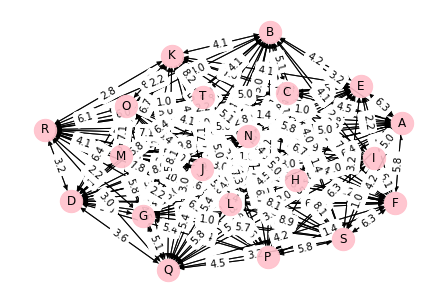

In [38]:
G        = nx.from_numpy_matrix(np.matrix(distance.round(1)), create_using=nx.DiGraph)  # Convert our matrix to a matrix readable by networkx
layout   = nx.spring_layout(G)                                                 # Position the nodes in a plane
labels   = nx.get_edge_attributes(G, "weight")                                 # We recover the weight of the edges

for i in range(number_cities):                                    # Add the name of the cities
    G.add_node(i, desc=cities[i])

node_labels = nx.get_node_attributes(G, 'desc')                   # Get the names of cities
    
nx.draw(G, layout, edge_color='black', width=1, linewidths=1,\
        node_size=500, node_color='pink', alpha=0.9)              # Graph configuration

nx.draw_networkx_labels      (G, pos=layout, labels=node_labels)  # We add the labels of the nodes to the graph
nx.draw_networkx_edge_labels (G, pos=layout, edge_labels=labels)  # We add the labels of the edge to the graph
plt.savefig("Graph.png", format="PNG")                            # We save the graph in a png file
plt.show()                                                        # Display the graph

## <strong> STEP 3: Modeling the problem </strong>

### - Definition of the formal problem

The ADEME wants to find new solutions to regulate and reduce the environmental impact of products deliveries.

For this, our structure CesiCDP must put in place new technologies to optimize the management of resources and the logistics of road traffic. So, we must manage a delivery round thanks to operational research and the VRP (Vehicle Routing Problem) problem.
 
The algorithmic problem therefore consists in calculating a route on a road network making it possible to link a subset of cities together, then to return to its starting point, to minimize the total duration of the tour. This optimization will have to take into account the traffic planned on each axis for the different time slots.

### Mathematical formulation :  

The VRP formulation that we present here corresponds to the mathematical formulation used in linear integer programming. It translates the natural modeling of the problem by the definition of a binary variable Xijk equal to 1 if the vehicle k crosses the arc (Vi, Vj), denoted more simply (i, j).
 
We assume that the graph G = (V, E) is complete, so that all the vertices are connected to each other. This means that a city can be visited from any other city.
  
  
The other constants of the problem are as follows:  
<strong> n </strong> number of clients (or vertices) 
<strong> m </strong> number of vehicles  
<strong> Q </strong> vehicle capacity  
<strong> qi </strong> request from client i  
<strong> Cij </strong> the cost of the edge between vertices i and j (distance or travel time)  

The decision variables of the problem are the <strong> xijk </strong> mentioned above:  
  
<strong> Xijk = 1 if (i, j) </strong> is traveled by vehicle <strong> k </strong>,  
<strong> Xijk = 0 </strong> otherwise.  
 
Thus, as an optimization problem, the VRP is written:

### 1) $\sum \limits _{i=1} ^{n} \sum \limits _{i=1} ^{m} Cij \sum \limits _{i=1} ^{m} Xijk$

<br>

A complete graph with n vertices has n (n − 1) 2 edges:  

### 2)  $\sum \limits _{i=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ j ≤ n$

### 3)  $\sum \limits _{j=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ i ≤ n$

### 4)  $\sum \limits _{i=1} ^{n} \sum \limits _{l=1} ^{n} Xijk = \sum \limits _{l=1} ^{n}\sum \limits _{j=1} ^{n} Xijk$

### 5)  $\sum \limits _{j=1} ^{n} X0jk = 1 ∀ 1 ≤ k ≤ m$

### 6)  $\sum \limits _{i=1} ^{n} Xi0k = 1 ∀ 1 ≤ k ≤ m$

### 7)  $\sum \limits _{i=1} ^{n} \sum \limits _{j=1} ^{n} Xijk ≤ Q ∀ 1 ≤ k ≤ m$


#### Xijk ∈ 0, 1 ∀ 0 ≤ i, j ≤ n; 1 ≤ k ≤ m

Under this formulation, 
(1) means that the objective of the optimization problem is to minimize the sum of the costs of all the routes.  
The constraints (2) and (3) require that each customer be served once and only once and the constraints (4) ensure flow conservation.  
Constraints (5) ensure that each tour begins and ends at the depot.  
Finally, the constraints (6) are the capacity constraints and the constraints (7) are binary constraints on the Xijk decision variables.



### - The complexity study of this problem

### Proof that VRP has "at least" the complexity of TSP  

The problem of vehicle tours is NP-Hard.  
  
Since this is not a decision problem (its return type is not bool), it cannot be in NP, although it has decision versions that are.  
  
This problem is a natural generalization of a problem that is already NP Difficult, in particular the traveling salesman problem or TSP. To prove that a problem is NP-Hard, reduces  it to another NP-Hard problem. The TSP is trivially reduced to a VRP instance with an available vehicle.  
  
  
  
### Proof that TSP is NP-Complete  

You have to show two things, that Traveling Salesman (TSP) is in NP and that TSP is NP-Hard. These requirements derive from the definition of NP-Completeness.  

**Part 1: TSP is in NP**

Proof: Let S be an index which is a sequence of vertices V = v1, ..., vn.  
We then check two things, that each edge crossed by adjacent vertices is an edge in G (usually not necessary, since G is traditionally a complete graph), such that the sum of these edge weights is less than or equal to k.  
Second, we check that every vertex of G is in V, which ensures that every node has been crossed. We accept S if and only if S satisfies these two questions, otherwise we reject. These two checks are clearly polynomial, so our algorithm forms a checker with the index S, and TSP is therefore in NP.
  
  
**Part 2: TSP is NP-Hard**


Proof: To show that TSP is NP-Hard, we have to show that any problem y in NP reduces to TSP in polynomial time.  
   
To do this, consider the decisional version of the Hamiltonian cycle (HC). It is well known that HC is NP-Complete, therefore HC is NP-Hard and each "Y" problem in NP reduces to HC in polynomial time. If we reduce HC to TSP in polynomial time, then we will have shown that any "Y" in NP reduced to TSP is a polynomial time, since the sum of two polynomials is also a polynomial.  
  
  
**Recall that the decision version of HC is:**  
Given a graph G = (V, E), is there a simple cycle in G that run through each vertex exactly once?  
Now observe that a simple cycle over n vertices has n edges.  
  
  
  
**Now to reduce HC to TSP use the following algorithm:**  
   
Take G = (V, E), set all edge weights equal to 1, and let k = | V | = n,  k is equal to the number of nodes in G.  
Any edge that is not at the origin in G then receives a weight of 2 (traditionally TSP is on a complete graph, so we have to add these extra edges). Then pass this modified graph in TSP, asking if there is a turn on G with a cost of at most k.  
If the answer to TSP is YES, then HC is YES. Likewise, if TSP is NO, then HC is NO.  
   
Proof: We have to show that the reduction takes a polynomial time and that the solutions of HC correspond 1-1 with the solutions of TSP using the reduction. Obviously, the reduction takes a polynomial time, so we end up with the latter.  
   
First direction: HC has a YES response => TSP has a YES response.   
Proof: If HC has a YES answer, then there exists a simple cycle C which visits each node exactly once, so C has n edges. Since each edge has a weight of 1 in the corresponding TSP instance for the edges that are in the HC graph, there is a round of weight n. Since k = n, and given that there is a round of weight n, it follows that TSP has a YES answer.  
   
Second direction: HC has a NO response => TSP has a NO response. Proof: If HC has an answer NO, then there is no simple cycle C in G that visits each vertex exactly once.  
Now suppose that TSP has a YES response. Then there is a tower that visits each vertex once with a weight of at most k. Since the tour requires that each node be crossed, there are n edges, and since k = n, each edge crossed must have a weight of 1, which implies that these edges are in the graph HC. Then do this round and cross the same edges in the HC instance. This forms a Hamiltonian cycle, a contradiction.  
   
This concludes part 2. Since we have shown that TSP is in both NP and NP-Hard, we have that TSP is NP-Complete, as required.  
  
  
### Conclusion

**Given that VRP is "at least" of the same complexity as TSP and that VRP is not NP. This means that VRP is necessarily NP-hard.**

# STEP 4 : Algorithmic Modeling

## 1 - Description of the algorithm used to solve VRP

### Why use the ant colony algorithm ?

According to studies carried out to know the best algorithm.  
   
For a little number of nodes:   
     
Taboo search and simulated annealing have better performance than other algorithms. Whether it is on the quality of the solution, the speed of the algorithm but also on the stability of the results, taboo search and simulated annealing have the best performances. It has been noted that the difference in the quality of the solution is particularly visible for larger test cases.  
   
For a case of a large number of nodes: The taboo search and simulated annealing methods give a solution with very similar and powerful differences. But a better result in almost all cases gives the ant colony optimization algorithm.  
 
**Conclusion :**  
The most suitable algorithm is therefore the ant algorithm, because we have a large number of nodes.

### Explanation of the ant colony algorithm

The original idea comes from the observation of the ant’s exploitation of food resources. Indeed,  although individually having limited cognitive abilities, are collectively able to find the shortest path between a food source and their nest.<br>
 <br>
Biologists have observed, in a series of experiments carried out starting in 1989, that an ant colony having the choice between two paths of unequal length leading to a food source tended to use the shorter path.<br>
A model explaining this behavior is as follows:<br>
 <br>
1.	an ant (called a "scout") roams more or less randomly in the environment around the colony;<br>
2.	if it discovers a source of food, it returns more or less directly to the nest, leaving a trail of pheromones in its path;<br>
3.	these pheromones being attractive, the ants passing nearby will tend to follow, more or less directly, this trail;<br>
4.	returning to the nest, these same ants will reinforce the trail;<br>
5.	if two tracks are possible to reach the same food source, the shorter one will be, at the same time, traveled by more ants than the long one;<br>
6.	the short track will therefore be more and more reinforced, and therefore more and more attractive;<br>
7.	the long track will eventually disappear, the pheromones being volatile;<br>
8.	eventually, all the ants determined and "chose" the shortest trail.<br>
 <br>
 <br>
 <br>
The ant colony algorithm aims to solve the traveling salesman problem, where the goal is to find the shortest path to connect a set of cities.<br>
The general algorithm is relatively simple, and relies on a set of ants, each traveling a path among those possible.<br>
At each step, the ant chooses to move from one city to another according to few rules:<br>
 <br>
•	she can only visit each city once;<br>
•	the further a city is, the less likely it is to be chosen (this is "visibility");<br>
•	the greater the intensity of the pheromone track placed on the ridge between two towns, the more likely the route will be chosen;<br>
•	once its journey is complete, the ant deposits more pheromones on all the edges traveled if the journey is short;<br>
•	the pheromone tracks evaporate with each iteration.<br>

## 2 - code Python implémentant le modèle

In [7]:

'''
Matrice des distance
'''
print(distance)

'''
Recuperer les 
'''




          A          B          C         D         E
A  0.000000   6.000000   8.062258  3.162278  6.708204
B  6.000000   0.000000  10.630146  3.162278  6.708204
C  8.062258  10.630146   0.000000  9.848858  4.472136
D  3.162278   3.162278   9.848858  0.000000  7.000000
E  6.708204   6.708204   4.472136  7.000000  0.000000


'\nRecuperer les \n'

## 3 - Modèle linéaire

FAIRE X = Combinaison du chemin
ET Y le poids total
(Je pense (peut etre))

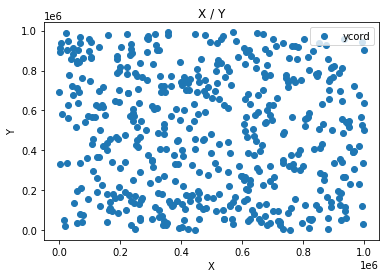

In [8]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

df.plot(x='xcord', y='ycord', style='o')  
plt.title('X / Y')  
plt.xlabel('X')  
plt.ylabel('Y')  
plt.show()

C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='xcord', ylabel='Density'>

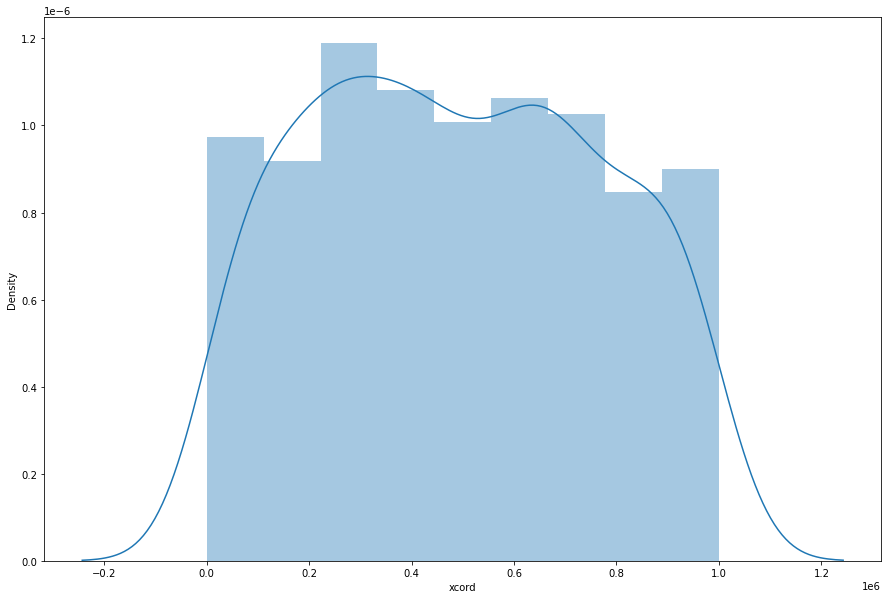

In [9]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df['xcord'])

In [11]:
X = df['xcord'].values.reshape(-1,1)
Y = df['ycord'].values.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model.score(X_test, Y_test)))
print("-------------------------\n\n")

Y_pred = regressor.predict(X_test)

df1 = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_pred.flatten()})
df1


[542138.96963922]
[[-0.11309214]]


,Actual,Predicted
0,696413,488358.569064
1,571168,514355.511103
2,26949,502645.498807
3,402104,496769.909890
4,55900,449520.919538
...,...,...
95,5688,513887.875114
96,958466,482035.135282
97,98134,481325.255935
98,690321,534933.304092


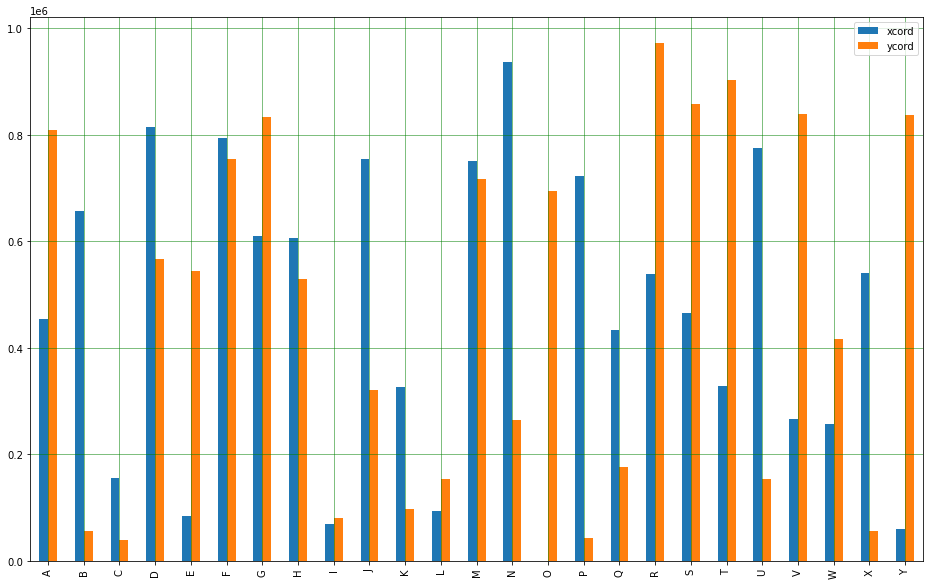

In [12]:
df2 = df.head(25)
df2.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

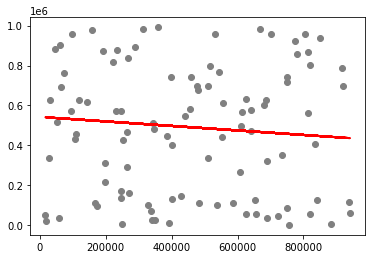

In [15]:
plt.scatter(X_test, Y_test,  color='gray')
plt.plot(X_test, Y_pred, color='red', linewidth=2)
plt.show()

Regression Coefficients: [[-0.02701411]]
-------------------------

coefficient of determination: -0.0032967439478772675
-------------------------

Variance score: -0.01649141857363179
-------------------------




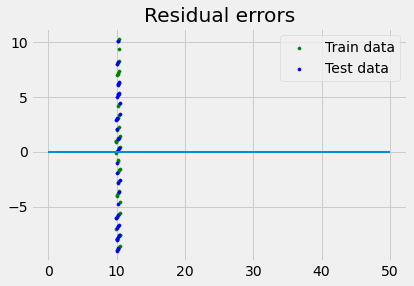

In [59]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

splited_coords = np.hsplit(coords,2)
X = splited_coords[0]
Y = splited_coords[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1)

# Create linear regression object AND Train the model using the training sets
model = LinearRegression().fit(X_train, Y_train)

# The regression coefficients
print('Regression Coefficients:', model.coef_)
print("-------------------------\n")

# coefficient of determination
r_sq = model.score(X, Y)
print('coefficient of determination:', r_sq)
print("-------------------------\n")

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model.score(X_test, Y_test)))
print("-------------------------\n\n")

## setting plot style
plt.style.use('fivethirtyeight')
 
## plotting residual errors in training data
plt.scatter(model.predict(X_train), model.predict(X_train) - Y_train,
            color = "green", s = 10, label = 'Train data')
 
## plotting residual errors in test data
plt.scatter(model.predict(X_test), model.predict(X_test) - Y_test,
            color = "blue", s = 10, label = 'Test data')
 
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
 
## plotting legend
plt.legend(loc = 'upper right')
 
## plot title
plt.title("Residual errors")
 
## method call for showing the plot
plt.show()

## CODE Python ALGORITHME DE FOURMI (CA MARCHE MAIS J AI PAS TOUT COMPRIS ENCORE ET J ARRIVE PAS A METTRE LES VRAI NOM DE VILLE)

In [101]:
import  random                     as rn
from    numpy.random import choice as np_choice

def AntColony(distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
    """
    Args:
        distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
        n_ants (int): Number of ants running per iteration
        n_best (int): Number of best ants who deposit pheromone
        n_iteration (int): Number of iterations
        decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
        alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
        beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
    Example:
        ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
    """
    
    pheromone              = np.ones(distances.shape) / len(distances)
    all_inds               = range(len(distances))
    shortest_path          = None
    all_time_shortest_path = ("placeholder", np.inf)
    
    
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, alpha, beta, all_inds)
        spread_pheronome(all_paths, n_best, pheromone, shortest_path=shortest_path)
        shortest_path = min(all_paths, key=lambda x: x[1])
        #print (shortest_path)
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path            
        pheromone = pheromone * decay            
    return all_time_shortest_path
    
def spread_pheronome(all_paths, n_best, pheromone, shortest_path):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / distances[move]

def gen_path_dist(path):
    total_dist = 0
    for ele in path:
        total_dist += distances[ele]
    return total_dist

def gen_all_paths(n_ants, pheromone, alpha, beta, all_inds):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, alpha, beta, all_inds)
        all_paths.append((path, gen_path_dist(path)))
    return all_paths

def gen_path(start, pheromone, alpha, beta, all_inds):
    path    = []
    visited = set()
    visited.add(start)
    prev    = start
    
    for i in range(len(distances) - 1):
        move = pick_move(pheromone[prev], distances[prev], visited, alpha, beta, all_inds)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start)) # going back to where we started    
    return path

def pick_move(pheromone, dist, visited, alpha, beta, all_inds):
    pheromone = np.copy(pheromone)
    pheromone[list(visited)] = 0

    row      = pheromone ** alpha * (( 1.0 / dist) ** beta)

    norm_row = row / row.sum()
    move     = np_choice(all_inds, 1, p=norm_row)[0]
    return move


number_of_ants                  = 2
distance_ant                    = distance_matrix(df.values, df.values)
distance_ant[distance_ant == 0] = np.inf

print(distance_ant)

shortest_path               =  AntColony(distance_ant, number_of_ants, 20, 100, 0.95, alpha=1, beta=1)

print ("shorted_path: {}".format(shortest_path))

[[       inf 3.         3.16227766 1.41421356 6.40312424]
 [3.                inf 5.         2.23606798 4.47213595]
 [3.16227766 5.                inf 4.47213595 6.08276253]
 [1.41421356 2.23606798 4.47213595        inf 6.40312424]
 [6.40312424 4.47213595 6.08276253 6.40312424        inf]]
shorted_path: ([(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)], 9.0)
